In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/EnsiasAIClub-CK/sample_data.csv
/kaggle/input/EnsiasAIClub-CK/train_data.csv
/kaggle/input/EnsiasAIClub-CK/test_data.csv


In [2]:
pip install fidle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# carga de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns
sns.__version__

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
#import math
#import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.utils import plot_model
from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler, Normalizer, Binarizer, MinMaxScaler
#from sklearn.metrics import mean_squared_error
# opción para ver todas las columnas
#pd.options.display.max_columns = 999
import fidle

In [4]:
train= pd.read_csv('/kaggle/input/EnsiasAIClub-CK/train_data.csv')

In [5]:
train['Datetime']=pd.to_datetime(train['Datetime'], infer_datetime_format=True, utc=True)
train = train.set_index('Datetime')

In [7]:
train= train.sort_values('Datetime')

In [9]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature,41932.0,18.794223,5.816396,3.247000,14.38000,18.77000,22.860000,39.78000
Humidity,41932.0,68.322970,15.550517,11.340000,58.36750,69.94000,81.500000,94.80000
WindSpeed,41932.0,1.958469,2.348605,0.050000,0.07800,0.08600,4.915000,6.48300
GeneralDiffuseFlows,41932.0,181.852878,263.567443,0.004000,0.06200,4.89550,317.200000,1163.00000
DiffuseFlows,41932.0,75.093093,124.152443,0.011000,0.12200,4.31800,101.300000,933.00000
PowerConsumption_Zone1,41932.0,32320.339175,7132.268087,13895.696200,26275.40426,32234.91377,37274.569030,52204.39512
PowerConsumption_Zone2,41932.0,21026.447763,5198.438443,8560.081466,16964.13374,20802.91060,24683.207865,37408.86076
PowerConsumption_Zone3,41932.0,17818.976229,6615.433440,5935.174070,13104.57831,16409.23391,21580.023753,47598.32636


In [10]:
def create_features(df):
    #Create time series features based on time series index .
    df['hour'] =  df.index.hour
    df['month'] =  df.index.month
    df['dayofweek'] =  df.index.dayofweek
    df['min']=df.index.minute
    #Monday is a 0 and suday is a six 
    return df

In [11]:
train = create_features(train)

In [12]:
def show_hist_boxplot(cols):
    cols = cols
    for col in cols:
        plt.figure(figsize=(12,2))
        plt.subplot(1,2,1)
        sns.histplot(data=train, x=col, bins=30, kde=True)
        plt.subplot(1,2,2)
        sns.boxplot(data=train, x=col)
        plt.show()

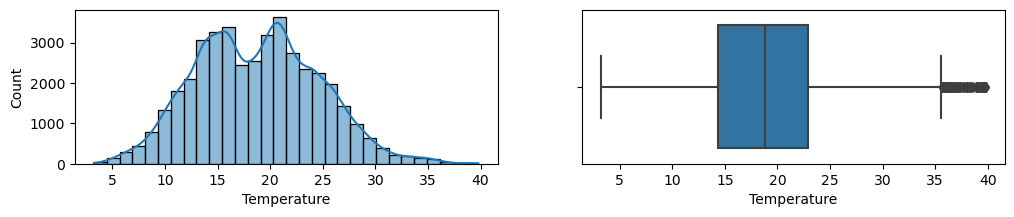

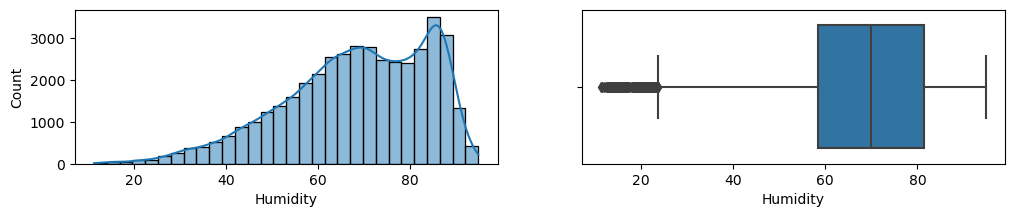

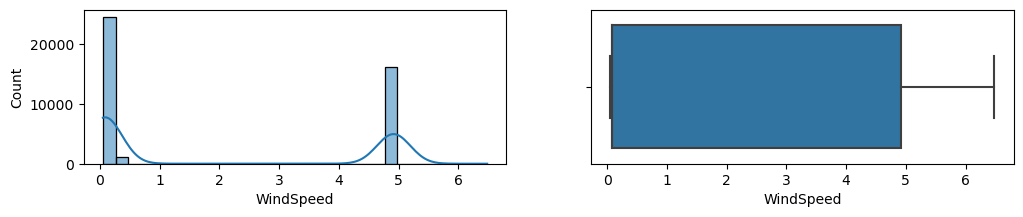

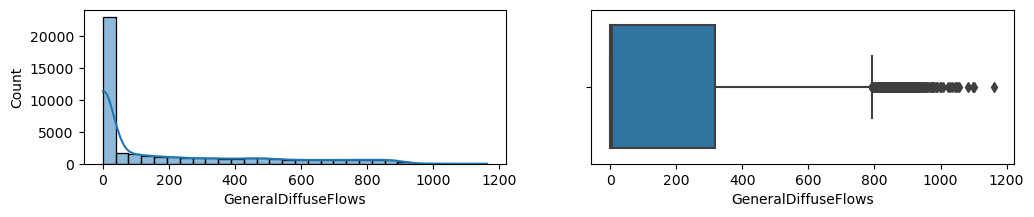

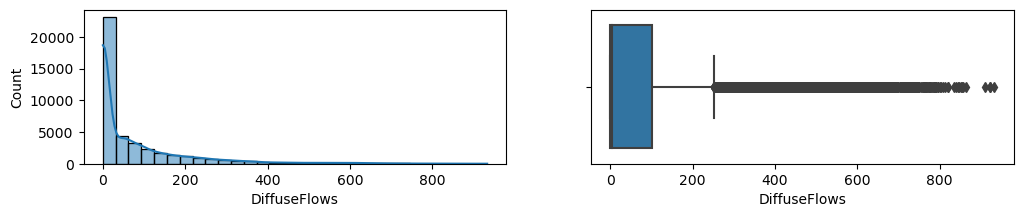

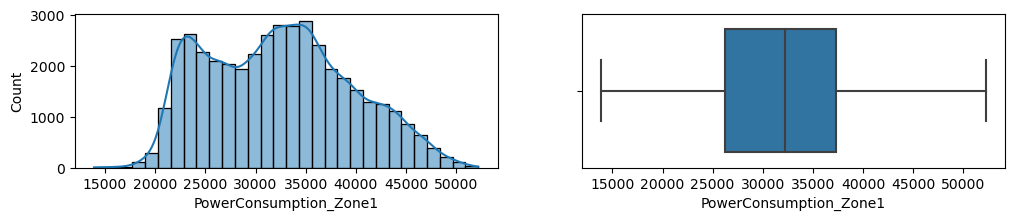

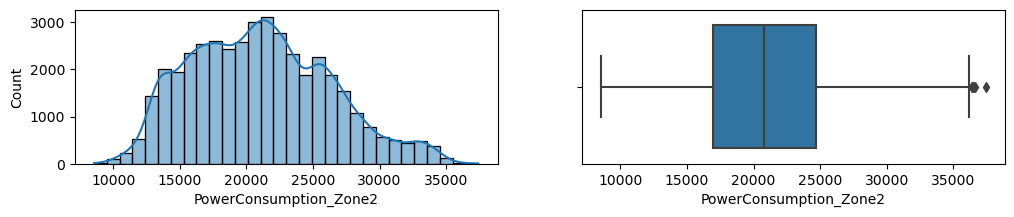

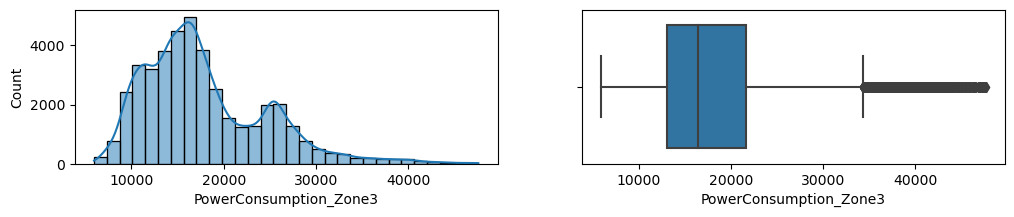

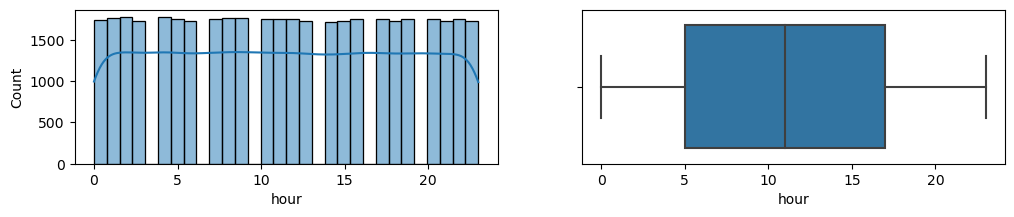

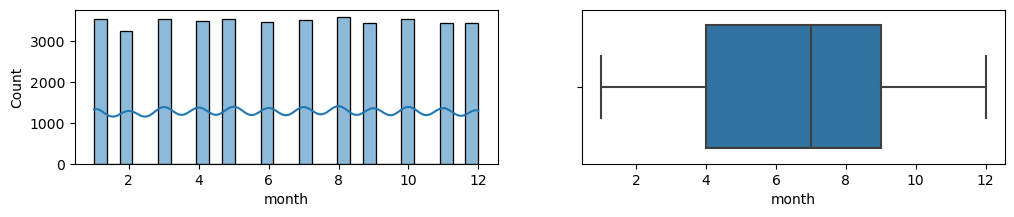

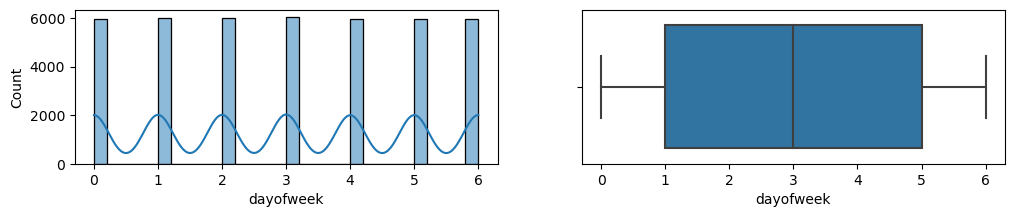

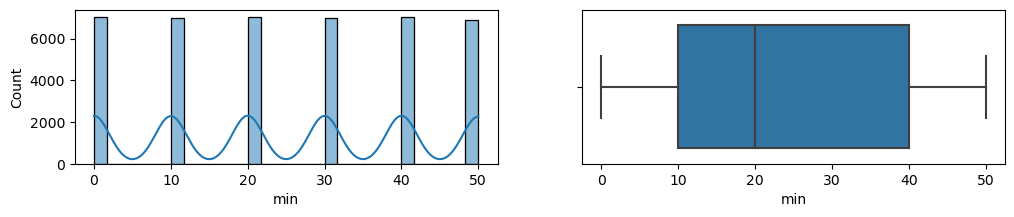

In [13]:
cols = train.columns 
show_hist_boxplot(cols)

In [ ]:
# loop through each column in the DataFrame
for col in train.columns:
    # calculate mean and standard deviation for the column
    mean = train[col].mean()
    std = train[col].std()
    # find values outside the range of 3 standard deviations from the mean
    outside_range = (train[col] < (mean - 3*std)) | (train[col] > (mean + 3*std))
    # assign NaN values to these values
    train.loc[outside_range, col] = np.nan

In [112]:
missing_values = train.isna().sum()

# Print the result
print(missing_values)

Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
hour                      0
month                     0
dayofweek                 0
min                       0
dtype: int64


In [78]:
train.interpolate(method='bfill', limit_direction='backward', inplace=True, axis=0)

In [14]:
new_order = ['month','dayofweek','hour', 'min','Temperature', 'Humidity', 'WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3']
train = train.reindex(columns=new_order)

In [15]:
feautres = ['Temperature' ,'Humidity' ,'WindSpeed' ,'GeneralDiffuseFlows','DiffuseFlows']
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(train[feautres])
df_normalized = pd.DataFrame(x_scaled, columns=train[feautres].columns, index=train.index)

In [16]:
df_normalized = df_normalized.join(train[['month','dayofweek','hour','min','PowerConsumption_Zone1' ,'PowerConsumption_Zone2' ,'PowerConsumption_Zone3']])

In [17]:
df_normalized.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature,41932.0,-3.145014e-16,1.000012,-2.673031,-0.758937,-0.004165,0.699028,3.608081
Humidity,41932.0,9.814613e-16,1.000012,-3.664422,-0.640209,0.103987,0.847379,1.702667
WindSpeed,41932.0,-9.218145e-17,1.000012,-0.812606,-0.800684,-0.797278,1.258861,1.926499
GeneralDiffuseFlows,41932.0,-5.151316e-17,1.000012,-0.689960,-0.689740,-0.671401,0.513526,3.722610
DiffuseFlows,41932.0,-9.760389e-17,1.000012,-0.604764,-0.603870,-0.570073,0.211089,6.910191
month,41932.0,6.508180e+00,3.441454,1.000000,4.000000,7.000000,9.000000,12.000000
dayofweek,41932.0,2.998498e+00,1.997929,0.000000,1.000000,3.000000,5.000000,6.000000
hour,41932.0,1.147558e+01,6.921312,0.000000,5.000000,11.000000,17.000000,23.000000
min,41932.0,2.494753e+01,17.053733,0.000000,10.000000,20.000000,40.000000,50.000000
PowerConsumption_Zone1,41932.0,3.232034e+04,7132.268087,13895.696200,26275.404260,32234.913770,37274.569030,52204.395120


To generate the first model from a time series, we start with only one energy variable, 'powerconsumption1'.

In [24]:
train_data = df_normalized 

In [25]:
import random

def convert2matrix(data_arr, past, future, shuffle=False):
    X, Y = [], []
    size = len(data_arr)
    for i in range(size - future - past + 1):
        d = i + past
        y_ind = i + past + future - 1
        X.append(data_arr.iloc[i:d, 0:8])
        Y.append(data_arr.iloc[y_ind, -3:])
    if shuffle:
        c = list(zip(X, Y))
        random.shuffle(c)
        X, Y = zip(*c)
    return np.array(X), np.array(Y)

In [26]:
# Create windows
past, future = (1, 0)
X_train, y_train = convert2matrix(train_data, past, future, shuffle=True)

In [27]:
X_train.shape

(41932, 1, 8)

In [70]:
#features = ['Datetime' ,'Temperature' ,'Humidity' ,'WindSpeed' ,'GeneralDiffuseFlows','DiffuseFlows']
def create_model_lstm_multi(past=72, learning_rate=1e-13):
    learning_rate=learning_rate
    past=past
    inputs = keras.layers.Input(shape = (1,8))
    lstm_out_1 = keras.layers.LSTM(64, return_sequences=True, activation="relu")(inputs)
    lstm_out_2 = keras.layers.LSTM(256, return_sequences=False, activation="relu")(lstm_out_1)
    outputs = layers.Dense(3)(lstm_out_2)
    model = keras.Model(inputs=inputs, outputs=outputs, name='lstm_multivariate')

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer= 'adam', loss="mse")
    model.summary()
    path_checkpoint = "model_checkpoint.h5"
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=0,
        save_weights_only=True,
        save_best_only=True)
    return model, es_callback, modelckpt_callback 

In [71]:
model_lstm_multi, es_callback, modelckpt_callback = create_model_lstm_multi(past=1, learning_rate=1e-3)

Model: "lstm_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 1, 64)             18688     
                                                                 
 lstm_11 (LSTM)              (None, 256)               328704    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 348,163
Trainable params: 348,163
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_lstm_multi.fit(X_train, y_train,
                    epochs=100,validation_split=0.2, shuffle=True,
                    batch_size = 50, callbacks=[es_callback, modelckpt_callback],
                    verbose = 1)

Epoch 1/100
671/671 [==============================] - 9s 10ms/step - loss: 226971824.0000 - val_loss: 122033624.0000


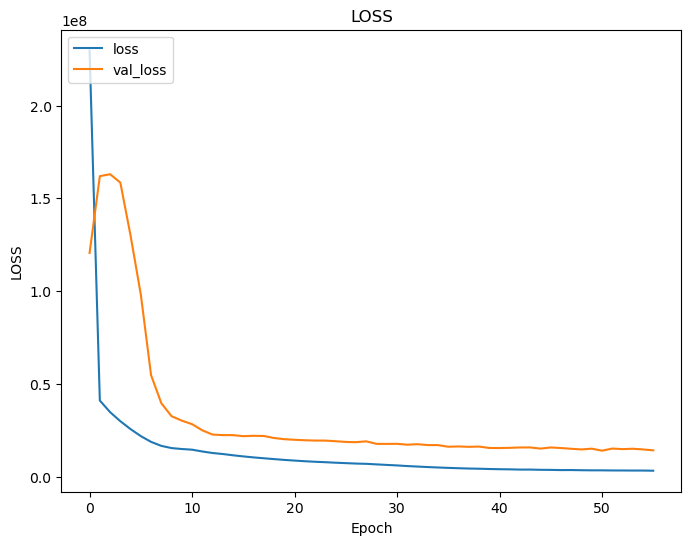

In [64]:
fidle.scrawler.history( history, plot={
                        'LOSS':['loss','val_loss']}, save_as='01-history')

In [65]:
results = model_lstm_multi.evaluate(X_train, y_train, verbose=1)
print('Test Loss: {}'.format(results))

1311/1311 [==============================] - 4s 3ms/step - loss: 5464588.5000
Test Loss: 5464588.5


1311/1311 [==============================] - 4s 3ms/step
max deviation:  17459.24661875
RMSE:  2533.3737384535925
MAE:  1878.292150563606


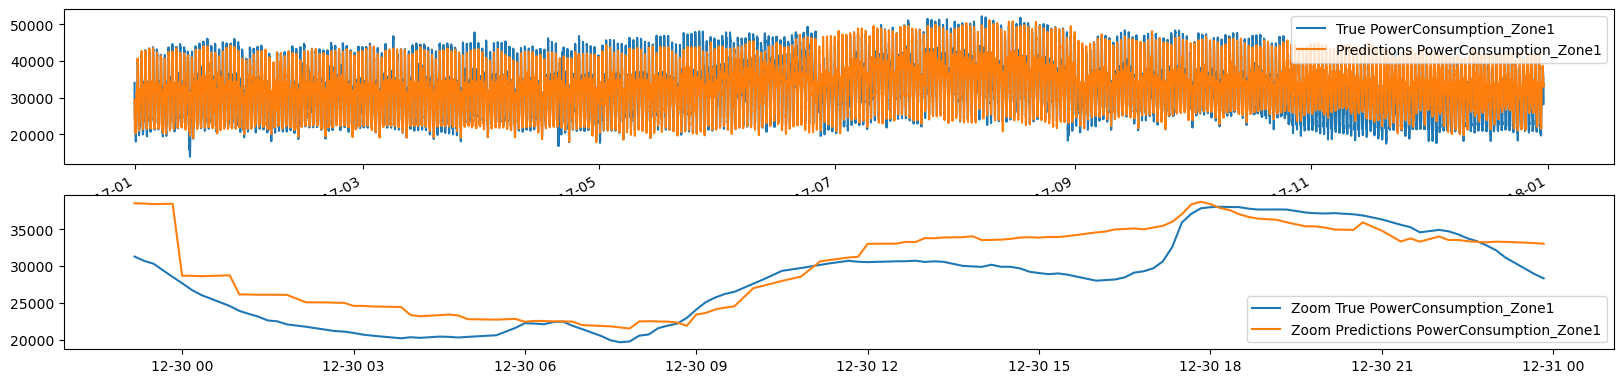

In [67]:
X_train1, y_train1 = convert2matrix(train_data, past, future)
def show_result_model(model , col):
    model = model
    y_pred = model.predict(X_train1)[:,col]
    y_target = y_train1[:, col] 
    diff = y_pred - y_target
    print('max deviation: ', np.abs(y_pred - y_target).max())
    print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
    print('MAE: ', np.abs(y_pred - y_target).mean())
    
    i = col+1
    load_target = 'PowerConsumption_Zone%i' % i

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5))

    train.plot(y=load_target, ax=ax1)
    
    ax1.plot(train.index[0:], y_pred)
    ax1.legend(['True {0}'.format(load_target), 'Predictions {0}'.format(load_target)])
    ax2.plot(train.index[-24*5:],y_target[-24*5:])
    index_cor = train.index[0:]
    ax2.plot(index_cor[-24*5:],y_pred[-24*5:])
    #ax2.grid(True)
    ax2.legend(['Zoom True {0}'.format(load_target), 'Zoom Predictions {0}'.format(load_target)])
    plt.show()
show_result_model(model_lstm_multi ,0)

1311/1311 [==============================] - 5s 3ms/step
max deviation:  16617.382148124998
RMSE:  4183.378390452727
MAE:  3109.1045756395324


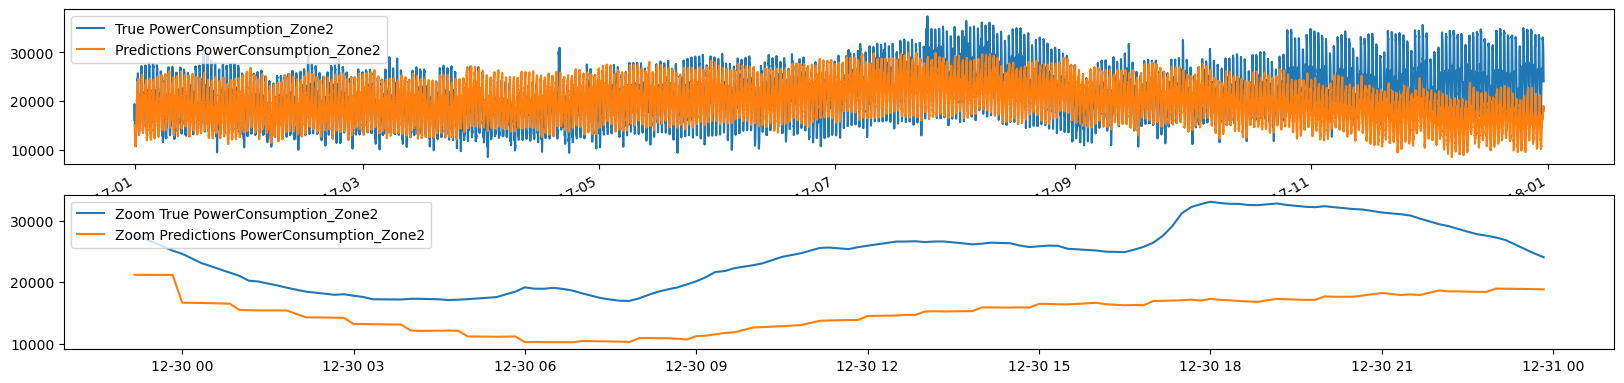

In [73]:
show_result_model(model_lstm_multi ,1)

In [19]:
test = pd.read_csv('/kaggle/input/EnsiasAIClub-CK/test_data.csv')
test['Datetime']=pd.to_datetime(test['Datetime'], infer_datetime_format=True, utc=True)
test = test.set_index('Datetime')

In [20]:
test = create_features(test)

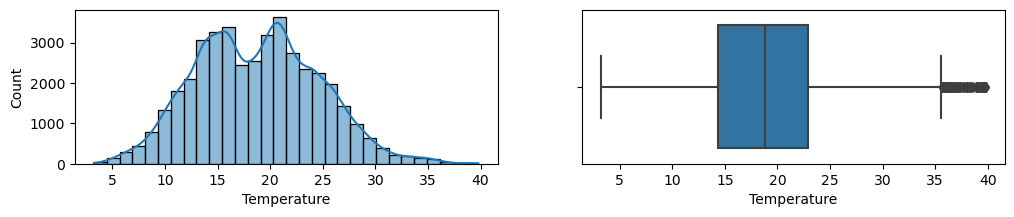

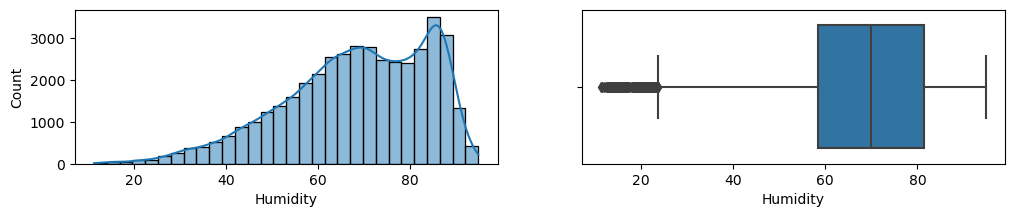

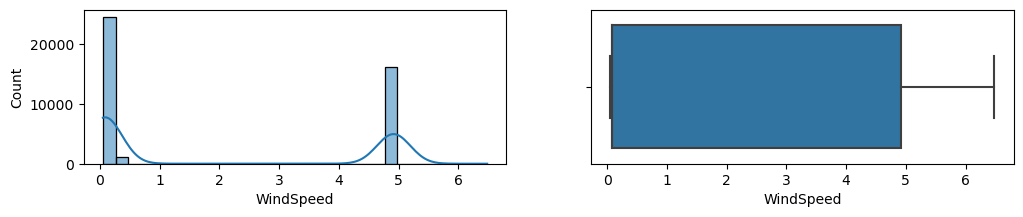

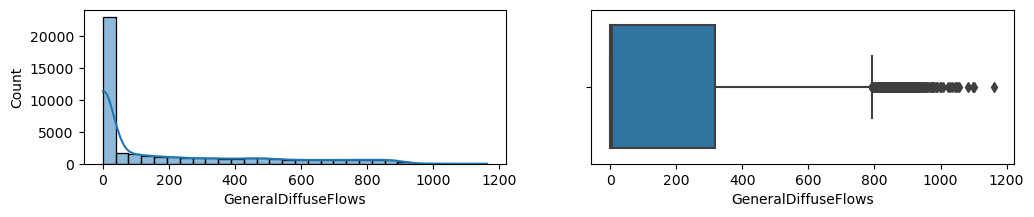

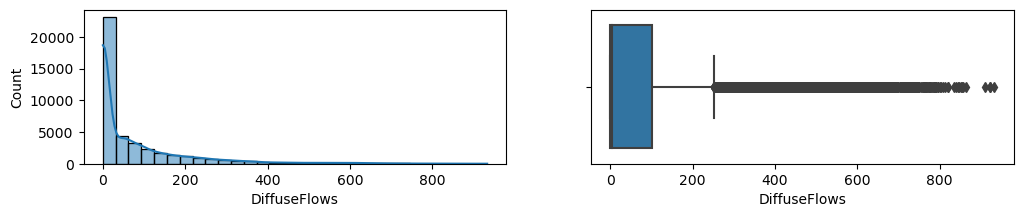

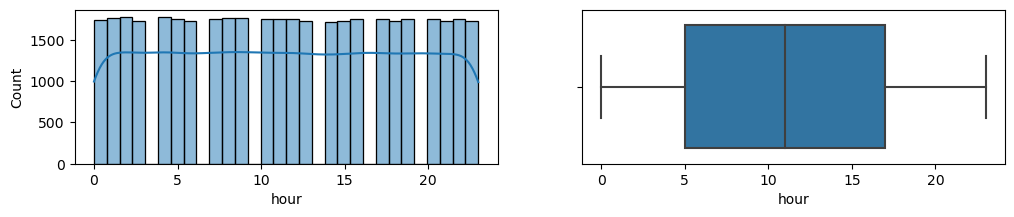

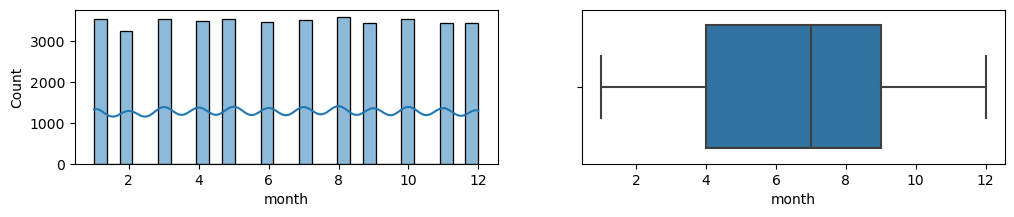

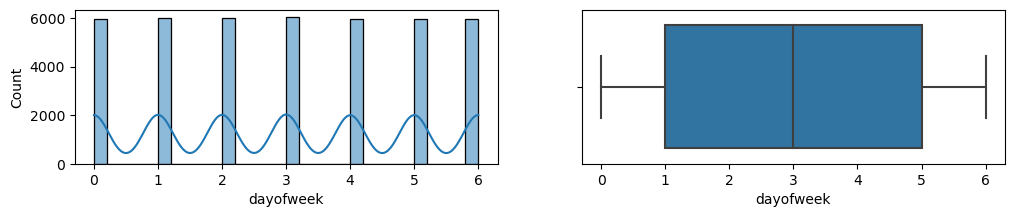

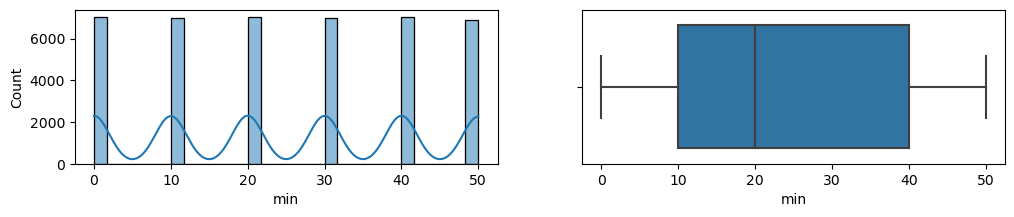

In [21]:
cols = test.columns 
show_hist_boxplot(cols)

In [143]:
# loop through each column in the DataFrame
for col in test.columns:
    # calculate mean and standard deviation for the column
    mean = test[col].mean()
    std = test[col].std()
    # find values outside the range of 3 standard deviations from the mean
    outside_range = (test[col] < (mean - 3*std)) | (test[col] > (mean + 3*std))
    # assign NaN values to these values
    test.loc[outside_range, col] = np.nan

In [137]:
missing_values = test.isna().sum()

# Print the result
print(missing_values)

Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
hour                   0
month                  0
dayofweek              0
min                    0
dtype: int64


In [138]:
test.interpolate(method='bfill', limit_direction='backward', inplace=True, axis=0)

In [22]:
means = scaler.mean_
stds = scaler.scale_
df_normalized_test = (test[feautres] - means) / stds

In [140]:
df_normalized_test.describe()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
count,10483.000000,10483.000000,10483.000000,10483.000000,10483.000000
mean,0.013526,-0.020405,0.002052,0.016072,-0.002563
std,0.999226,1.000153,1.000578,1.015697,1.002441
min,-2.622484,-3.664422,-0.811329,-0.689949,-0.604611
25%,-0.731428,-0.667701,-0.800684,-0.689740,-0.603870
50%,0.002713,0.081479,-0.797278,-0.668702,-0.565006
75%,0.722239,0.821656,1.258861,0.556590,0.201423
max,3.647625,1.683374,1.806000,3.567050,6.934355


In [45]:
df_normalized.head(1)

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,month,dayofweek,hour,min,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,,,,,
2017-01-01 00:00:00+00:00,-2.1036,0.352213,-0.798555,-0.689782,-0.603895,1,6,0,0,34055.6962,16128.87538,20240.96386


In [46]:
df_normalized_test

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Datetime,,,,,
2017-02-12 14:40:00+00:00,-0.948059,0.930979,-0.802387,-0.208120,0.429372
2017-11-22 15:30:00+00:00,-0.528551,-1.282479,1.262267,-0.211155,0.360907
2017-10-15 01:50:00+00:00,-0.265498,1.123901,-0.800259,-0.689767,-0.603806
2017-09-11 23:00:00+00:00,0.492713,-0.501788,-0.718933,-0.689588,-0.604015
2017-12-26 01:20:00+00:00,-1.726901,0.744488,-0.800259,-0.689725,-0.603838
...,...,...,...,...,...
2017-02-01 13:00:00+00:00,-1.101077,-1.359648,1.260990,1.515938,4.417259
2017-05-17 14:40:00+00:00,0.499590,-0.155815,1.260564,2.269454,1.923520
2017-09-03 07:00:00+00:00,0.265765,-0.900493,1.262693,-0.653931,-0.555196


In [47]:
df_normalized_test = df_normalized_test.join(test[['month','dayofweek','hour','min']])

In [48]:
df_normalized_test.to_csv('/kaggle/working/df_normalized_test_with_outlier.csv')

In [145]:
df_normalized_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature,10483.0,0.013526,0.999226,-2.622484,-0.731428,0.002713,0.722239,3.647625
Humidity,10483.0,-0.020405,1.000153,-3.664422,-0.667701,0.081479,0.821656,1.683374
WindSpeed,10483.0,0.002052,1.000578,-0.811329,-0.800684,-0.797278,1.258861,1.806000
GeneralDiffuseFlows,10483.0,0.016072,1.015697,-0.689949,-0.689740,-0.668702,0.556590,3.567050
DiffuseFlows,10483.0,-0.002563,1.002441,-0.604611,-0.603870,-0.565006,0.201423,6.934355
month,10483.0,6.522179,3.437695,1.000000,4.000000,7.000000,10.000000,12.000000
dayofweek,10483.0,3.006296,2.008320,0.000000,1.000000,3.000000,5.000000,6.000000
hour,10483.0,11.598588,6.925179,0.000000,6.000000,12.000000,18.000000,23.000000
min,10483.0,25.212248,17.175044,0.000000,10.000000,30.000000,40.000000,50.000000


In [49]:
def convert2matrix_test(data_arr, past, future):
    X  = []
    size = len(data_arr)
    for i in range(size - future - past + 1):
        d = i + past
        y_ind = i + past + future - 1
        X.append(data_arr.iloc[i:d, 0:8])
   
    return np.array(X)

In [50]:
# Create windows
past, future = (1, 0)
X_test = convert2matrix_test(df_normalized_test, past, future)

In [51]:
X_test.shape

(10483, 1, 8)

In [52]:
y_pred = model_lstm_multi.predict(X_test)

328/328 [==============================] - 1s 3ms/step


In [53]:
Sample = pd.read_csv('/kaggle/input/EnsiasAIClub-CK/sample_data.csv')

In [54]:
Sample.head()

,Datetime,predicted_Zone1,predicted_Zone2,predicted_Zone3
0,2/12/2017 14:40,30000,10000,20000
1,11/22/2017 15:30,30000,10000,20000
2,10/15/2017 1:50,30000,10000,20000
3,9/11/2017 23:00,30000,10000,20000
4,12/26/2017 1:20,30000,10000,20000


In [55]:
df = pd.DataFrame(y_pred, columns=['predicted_Zone1','predicted_Zone2','predicted_Zone3'], index=test.index)

In [56]:
df.head(1)

,predicted_Zone1,predicted_Zone2,predicted_Zone3
Datetime,,,
2017-02-12 14:40:00+00:00,32264.253906,18740.242188,17228.175781


In [57]:
df = df.reset_index(drop=False)
df['Datetime'] = df['Datetime'].dt.strftime('%m/%d/%Y %H:%M')

In [58]:
df['Datetime'] = Sample['Datetime']

In [59]:
df.head(1)

,Datetime,predicted_Zone1,predicted_Zone2,predicted_Zone3
0,2/12/2017 14:40,32264.253906,18740.242188,17228.175781


In [60]:
df.to_csv('/kaggle/working/sample.csv', index=False)

In [173]:
past, future = (1, 0)
X_train, y_train = convert2matrix(train_data, past, future, shuffle=True)

In [174]:
X_train = X_train.reshape(41932, 8)
y_train = y_train.reshape(41932, 3)

In [192]:
def create_model_dense(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(50, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(200, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(10, activation='relu', name='Dense_n3'))
    model.add(keras.layers.Dense(3, name='Output'))
  
    model.compile(optimizer = 'adam',
                    loss      = 'mse',
                    metrics   = ['mae', 'mse'] 
                 )
    model.summary()

    #es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=8)
    
    return model,es_callback

In [193]:
model, es_callback = create_model_dense(shape=8)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 50)                450       
                                                                 
 Dense_n2 (Dense)            (None, 200)               10200     
                                                                 
 Dense_n3 (Dense)            (None, 10)                2010      
                                                                 
 Output (Dense)              (None, 3)                 33        
                                                                 
Total params: 12,693
Trainable params: 12,693
Non-trainable params: 0
_________________________________________________________________


In [194]:
# 2. ajuste del modelo con fit
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.2, shuffle=True, batch_size = 64, verbose =1)

Epoch 1/20
525/525 [==============================] - 2s 3ms/step - loss: 238560336.0000 - mae: 11612.5732 - mse: 238560336.0000 - val_loss: 144946848.0000 - val_mae: 10101.8496 - val_mse: 144946848.0000
Epoch 2/20
525/525 [==============================] - 1s 2ms/step - loss: 38117272.0000 - mae: 4807.4429 - mse: 38117272.0000 - val_loss: 165214064.0000 - val_mae: 11119.5547 - val_mse: 165214064.0000
Epoch 3/20
525/525 [==============================] - 1s 2ms/step - loss: 30988720.0000 - mae: 4314.3662 - mse: 30988720.0000 - val_loss: 154064064.0000 - val_mae: 10783.9873 - val_mse: 154064064.0000
Epoch 4/20
525/525 [==============================] - 1s 2ms/step - loss: 25319246.0000 - mae: 3880.4792 - mse: 25319246.0000 - val_loss: 109391912.0000 - val_mae: 8983.3350 - val_mse: 109391912.0000
Epoch 5/20
525/525 [==============================] - 1s 2ms/step - loss: 21105056.0000 - mae: 3518.9680 - mse: 21105056.0000 - val_loss: 73218664.0000 - val_mae: 7307.3818 - val_mse: 73218664.0

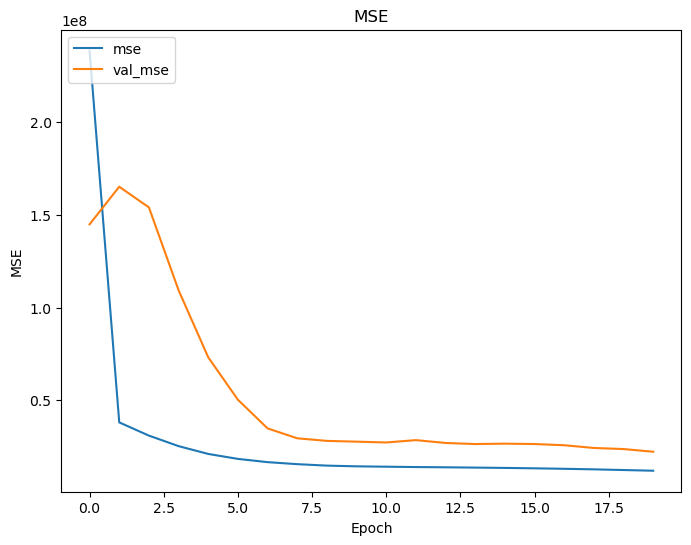

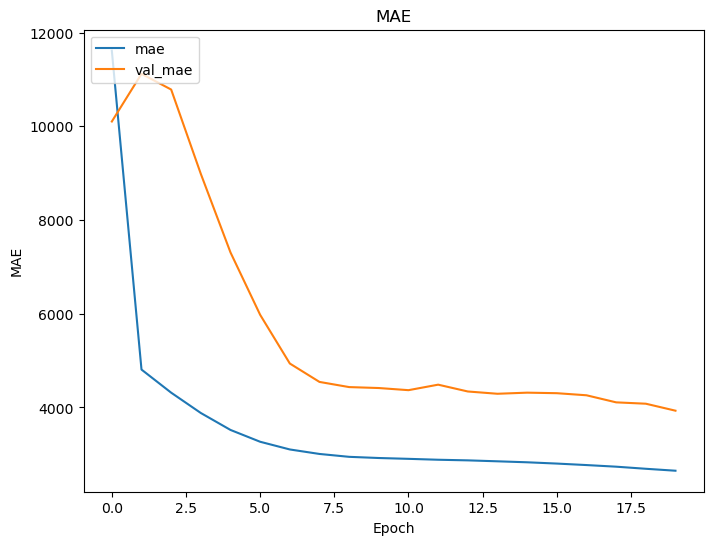

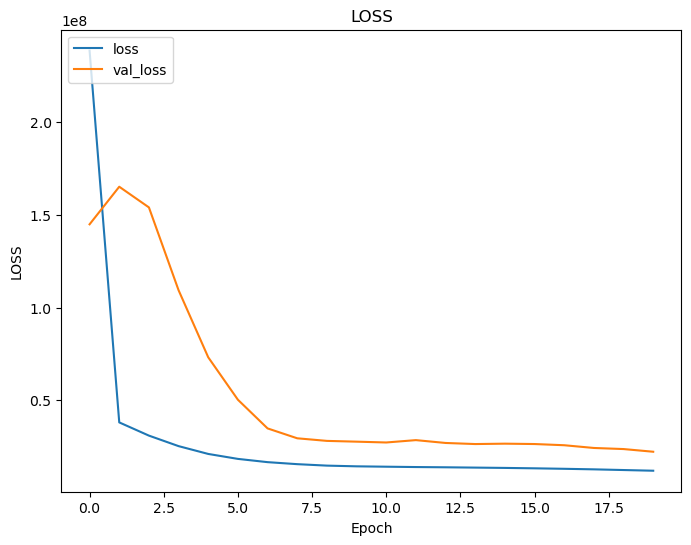

In [195]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

In [200]:
results = model.evaluate(X_train, y_train, verbose=1)
print('Test Loss: {}'.format(results))

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_3/Dense_n1/Relu' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_27/1234098939.py", line 1, in <module>
      results = model.evaluate(X_train, y_train, verbose=1)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1756, in test_step
      y_pred = self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/opt/conda/lib/python3.7/site-packages/keras/activations.py", line 318, in relu
      x, alpha=alpha, max_value=max_value, threshold=threshold
    File "/opt/conda/lib/python3.7/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_3/Dense_n1/Relu'
In[0] and In[1] has different ndims: [32,1,8] vs. [8,50]
	 [[{{node sequential_3/Dense_n1/Relu}}]] [Op:__inference_test_function_927910]

In [197]:
X_train , y_train = convert2matrix(train_data, past, future)
#X_train = X_train.reshape(41931, 5)
#y_train = y_train.reshape(41931, 3)

In [181]:
X_train = X_train.reshape(41932, 8)
y_train = y_train.reshape(41932, 3)

In [198]:
def show_result_model(model , col):
    model = model
    yy = model.predict(X_train)
    #y_pred = yy[:, col]* stds[col+5] + means[col+5]
    #y_target = y_train[:, col] * stds[col+5] + means[col+5]
    y_pred = yy[:, col]
    y_target = y_train[:, col]
    diff = y_pred - y_target
    print('max deviation: ', np.abs(y_pred - y_target).max())
    print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
    print('MAE: ', np.abs(y_pred - y_target).mean())
    
    i = col+1
    load_target = 'PowerConsumption_Zone%i' % i

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5))

    train.plot(y=load_target, ax=ax1)
    
    ax1.plot(train.index[0:], y_pred)
    ax1.legend(['True {0}'.format(load_target), 'Predictions {0}'.format(load_target)])
    ax2.plot(train.index[-24*5:],y_target[-24*5:])
    index_cor = train.index[0:]
    ax2.plot(index_cor[-24*5:],y_pred[-24*5:])
    #ax2.grid(True)
    ax2.legend(['Zoom True {0}'.format(load_target), 'Zoom Predictions {0}'.format(load_target)])
    plt.show()

In [199]:
show_result_model(model,2)

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 8), found shape=(None, 1, 8)


In [ ]:
### import pandas as pd
import numpy as np
from keras.utils import to_categorical
feautres = train.columns[1:]

# Get the timezone of the Datetime column in the train DataFrame
timezone = train['Datetime'].dt.tz

# Create a Timestamp object with the same timezone as the Datetime column
timestamp = pd.Timestamp("1970-01-01", tz=timezone)

# Convert the date and time data to a Unix timestamp
train['Datetime'] = (train['Datetime'] - timestamp) // pd.Timedelta(seconds=1)

# Normalize the timestamp data
#train['Datetime'] = (train['Datetime'] - train['Datetime'].min()) / (train['Datetime'].max() - train['Datetime'].min())

In [ ]:
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(train)
df_normalized = pd.DataFrame(x_scaled, columns=train.columns, index=train.index)
train_data = df_normalized 

In [ ]:
train_data.describe()

In [ ]:
import random

def convert2matrix(data_arr, past, future, shuffle=False):
    X, Y = [], []
    size = len(data_arr)
    for i in range(size - future - past + 1):
        d = i + past
        y_ind = i + past + future - 1
        X.append(data_arr.iloc[i:d, 0:6])
        Y.append(data_arr.iloc[y_ind, -3:])
    if shuffle:
        c = list(zip(X, Y))
        random.shuffle(c)
        X, Y = zip(*c)
    return np.array(X), np.array(Y)

In [ ]:
# Create windows
past, future = (1, 1)
X_train, y_train = convert2matrix(train_data, past, future, shuffle=True)

In [ ]:
print(X_train.shape) 
print(y_train.shape)

In [ ]:
#X_train = X_train.reshape(41931, 6)
#y_train = y_train.reshape(41931, 3)